<a href="https://colab.research.google.com/github/cyclingdata/tensorflow_practice_coursera/blob/master/S%2BP_Week_4_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-03 23:56:09--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2020-04-03 23:56:09 (8.48 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [5]:
import pandas as pd

temperatures = pd.read_csv('/tmp/daily-min-temperatures.csv')
temperatures

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


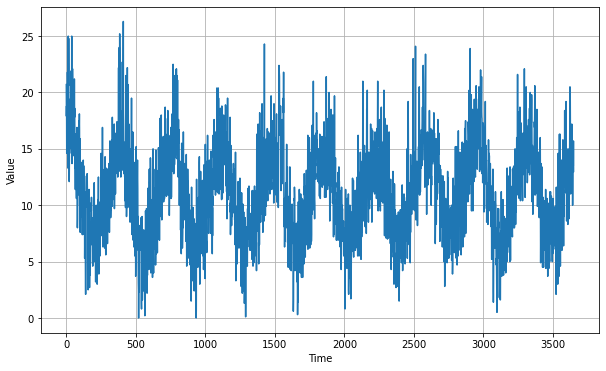

In [6]:
series = np.array(temperatures['Temp'])
time = np.array(range(temperatures.shape[0]))
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 365
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
9/9 [==============================] - 0s 52ms/step - loss: 35.9534 - mae: 36.4408 - lr: 1.0000e-08
Epoch 2/100
9/9 [==============================] - 1s 67ms/step - loss: 35.3457 - mae: 35.8545 - lr: 1.1220e-08
Epoch 3/100
9/9 [==============================] - 1s 66ms/step - loss: 34.3767 - mae: 34.9132 - lr: 1.2589e-08
Epoch 4/100
9/9 [==============================] - 1s 66ms/step - loss: 33.1613 - mae: 33.6987 - lr: 1.4125e-08
Epoch 5/100
9/9 [==============================] - 1s 64ms/step - loss: 31.5924 - mae: 32.1579 - lr: 1.5849e-08
Epoch 6/100
9/9 [==============================] - 1s 65ms/step - loss: 29.5606 - mae: 30.1361 - lr: 1.7783e-08
Epoch 7/100
9/9 [==============================] - 1s 66ms/step - loss: 26.8267 - mae: 27.4432 - lr: 1.9953e-08
Epoch 8/100
9/9 [==============================] - 1s 65ms/step - loss: 23.3166 - mae: 23.9532 - lr: 2.2387e-08
Ep

(1e-08, 0.0001, 0.0, 60.0)

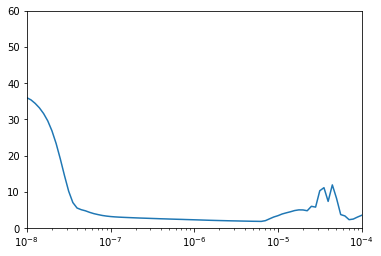

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/50
25/25 [==============================] - 0s 12ms/step - loss: 13.6713 - mae: 14.3551
Epoch 2/50
25/25 [==============================] - 0s 13ms/step - loss: 4.0531 - mae: 4.5449
Epoch 3/50
25/25 [==============================] - 0s 14ms/step - loss: 2.9277 - mae: 3.3944
Epoch 4/50
25/25 [==============================] - 0s 14ms/step - loss: 2.6451 - mae: 3.1094
Epoch 5/50
25/25 [==============================] - 0s 14ms/step - loss: 2.5209 - mae: 2.9840
Epoch 6/50
25/25 [==============================] - 0s 14ms/step - loss: 2.4376 - mae: 2.8986
Epoch 7/50
25/25 [==============================] - 0s 14ms/step - loss: 2.3744 - mae: 2.8358
Epoch 8/50
25/25 [==============================] - 0s 13ms/step - loss: 2.3253 - mae: 2.7861
Epoch 9/50
25/25 [==============================] - 0s 13ms/step - loss: 2.2845 - mae: 2.7460
Epoch 10/50
25/25 [==============================] - 0s 13ms/step - loss: 2.2544 - mae: 2.7139
Epoch 11/50
25/25 [==============================] - 0s 1

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

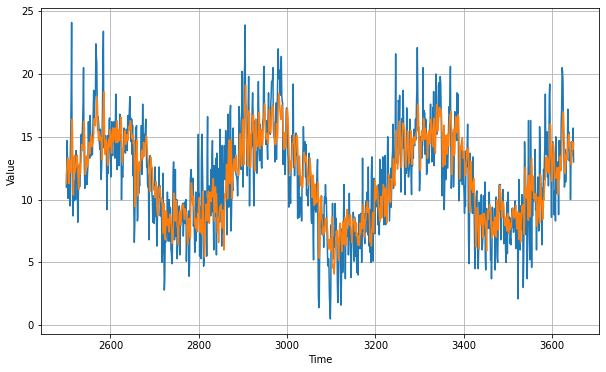

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.0134952

In [23]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.270748  12.400632  12.6778965 ... 14.361972  14.014021  14.510456 ]
